In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset

from model.CNN import CNN
from model.LSTM import LSTM
from libs import utils

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

In [3]:
ettm1 = utils.ET_preprocess('data/ETTm1.csv')
ettm1['id'] = 1
ettm2 = utils.ET_preprocess('data/ETTm2.csv')
ettm2['id'] = 2

In [4]:
ettm1_train, ettm1_valid, ettm1_test = utils.ET_data_split(ettm1)
ettm2_train, ettm2_valid, ettm2_test = utils.ET_data_split(ettm2)

train = pd.concat([ettm1_train, ettm2_train])
valid = pd.concat([ettm1_valid, ettm2_valid])
test = pd.concat([ettm1_test, ettm2_test])

(X_train, y_train), (X_valid, y_valid), (X_test, y_test), test_scaler = utils.ET_data2tensor(train, valid, test)

100%|██████████| 27979/27979 [00:49<00:00, 565.56it/s]


In [5]:
X_train

tensor([[[-1.0064, -1.0100, -1.0100,  ..., -1.0242, -1.0242, -1.0242],
         [-0.8246, -0.8138, -0.8353,  ..., -0.8246, -0.8353, -0.8138],
         [-1.0007, -1.0051, -1.0051,  ..., -1.0051, -1.0051, -1.0051],
         [-0.9452, -0.9518, -0.9581,  ..., -0.9452, -0.9518, -0.9389],
         [ 0.6391,  0.6563,  0.6479,  ...,  0.5620,  0.5620,  0.5791],
         [ 0.3475,  0.3573,  0.3426,  ...,  0.3475,  0.3475,  0.3426]],

        [[-1.0100, -1.0100, -1.0100,  ..., -1.0242, -1.0242, -1.0171],
         [-0.8138, -0.8353, -0.8353,  ..., -0.8353, -0.8138, -0.8031],
         [-1.0051, -1.0051, -1.0051,  ..., -1.0051, -1.0051, -1.0036],
         [-0.9518, -0.9581, -0.9518,  ..., -0.9518, -0.9389, -0.9323],
         [ 0.6563,  0.6479,  0.6479,  ...,  0.5620,  0.5791,  0.5963],
         [ 0.3573,  0.3426,  0.3426,  ...,  0.3475,  0.3426,  0.3525]],

        [[-1.0100, -1.0100, -1.0135,  ..., -1.0242, -1.0171, -0.9993],
         [-0.8353, -0.8353, -0.8138,  ..., -0.8138, -0.8031, -0.7708],
  

In [6]:
print('X Train shape ', X_train.shape)
print('X Valid shape ', X_valid.shape)
print('X Test shape', X_test.shape)

X Train shape  torch.Size([70059, 6, 20])
X Valid shape  torch.Size([41259, 6, 20])
X Test shape torch.Size([27979, 6, 20])


In [7]:
batch_size = 256

train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

valid_data = TensorDataset(X_valid, y_valid)
valid_loader = DataLoader(valid_data, shuffle=False, batch_size=batch_size)

test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

# Model

In [17]:
def choose_model(model_type):
    if model_type == 'singleLSTM':
        model = LSTM(6, 128, 1, 20, 1).cuda()
        save_path = 'results/singleLSTM/'
        save_file_name = save_path + 'SingleLSTMet.pth'
    elif model_type == 'stackedLSTM':
        model = LSTM(6, 128, 1, 20, 2).cuda()
        save_path = 'results/stackedLSTM/'
        save_file_name = save_path + 'StackedLSTMet.pth'
    elif model_type == 'CNN':
        model = CNN(6, [32, 64, 128], 1).cuda()
        save_path = 'results/CNN/'
        save_file_name = save_path + 'CNNet.pth'
    return model, save_path, save_file_name

In [36]:
model_type = 'CNN'
model, save_path, save_file_name = choose_model(model_type)
print(model)

CNN(
  (block1): Sequential(
    (0): Conv1d(6, 32, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (block3): Sequential(
    (0): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,))
    (1): ReLU()
  )
  (conv1): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
)


In [37]:
lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 5
n_epochs = 300

In [38]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
#     X = X.reshape(-1, 20, 6)
#     print(X)
    exmodel = CNN(6, [32, 64, 128], 1).cuda()
    output = exmodel(X.cuda())
    criterion = nn.MSELoss().cuda()
    print(output.shape)
    print(output)
    loss = criterion(output.reshape(-1), y.cuda())
    print(loss)

torch.Size([256, 6, 20])
torch.Size([256])
torch.Size([256, 1, 1])
tensor([[[0.0748]],

        [[0.0748]],

        [[0.0747]],

        [[0.0746]],

        [[0.0745]],

        [[0.0744]],

        [[0.0743]],

        [[0.0743]],

        [[0.0744]],

        [[0.0745]],

        [[0.0746]],

        [[0.0747]],

        [[0.0748]],

        [[0.0749]],

        [[0.0753]],

        [[0.0755]],

        [[0.0753]],

        [[0.0749]],

        [[0.0745]],

        [[0.0740]],

        [[0.0735]],

        [[0.0731]],

        [[0.0725]],

        [[0.0720]],

        [[0.0716]],

        [[0.0712]],

        [[0.0709]],

        [[0.0706]],

        [[0.0703]],

        [[0.0700]],

        [[0.0698]],

        [[0.0694]],

        [[0.0694]],

        [[0.0695]],

        [[0.0696]],

        [[0.0695]],

        [[0.0695]],

        [[0.0695]],

        [[0.0694]],

        [[0.0692]],

        [[0.0689]],

        [[0.0685]],

        [[0.0682]],

        [[0.0679]],

        [

# Train

In [39]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = []
    
    best_loss = 9999999999
    patience = 0
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            if model_type != 'CNN':
                data, target = data.reshape(-1, 20, 6).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in valid_loader:
            if model_type != 'CNN':
                data, target = data.reshape(-1, 20, 6).cuda(), target.cuda()
            else:
                data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.reshape(-1), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        
        if valid_loss < best_loss:
            best_loss = valid_loss
            patience = 0
            torch.save(model.state_dict(), save_file_name)
            print('Saving Model')
        else:
            patience += 1
            print('Patience for ', patience)
        if patience == 5:
            break

    model.load_state_dict(torch.load(save_file_name))

    return  model, avg_train_losses, avg_valid_losses

In [40]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        if model_type != 'CNN':
            data, target = data.reshape(-1, 20, 6).cuda(), target.cuda()
        else:
            data, target = data.cuda(), target.cuda()
        y_test.append(target.cpu().numpy())
        output = model(data)
        y_hat.append(output.reshape(-1).detach().cpu().numpy())
        loss = criterion(output.reshape(1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [41]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 0.91990 valid_loss: 0.69331
Saving Model
[  2/300] train_loss: 0.77409 valid_loss: 0.66718
Saving Model
[  3/300] train_loss: 0.77562 valid_loss: 0.63145
Saving Model
[  4/300] train_loss: 0.72625 valid_loss: 0.61976
Saving Model
[  5/300] train_loss: 0.69973 valid_loss: 0.61825
Saving Model
[  6/300] train_loss: 0.68066 valid_loss: 0.61155
Saving Model
[  7/300] train_loss: 0.65698 valid_loss: 0.60690
Saving Model
[  8/300] train_loss: 0.64234 valid_loss: 0.60253
Saving Model
[  9/300] train_loss: 0.62774 valid_loss: 0.59990
Saving Model
[ 10/300] train_loss: 0.61683 valid_loss: 0.60049
Patience for  1
[ 11/300] train_loss: 0.60826 valid_loss: 0.61023
Patience for  2
[ 12/300] train_loss: 0.60087 valid_loss: 0.61843
Patience for  3
[ 13/300] train_loss: 0.59351 valid_loss: 0.63000
Patience for  4
[ 14/300] train_loss: 0.58724 valid_loss: 0.64342
Patience for  5


In [42]:
test_loss, y_target, y_hat = evaluate_model(model, test_loader)

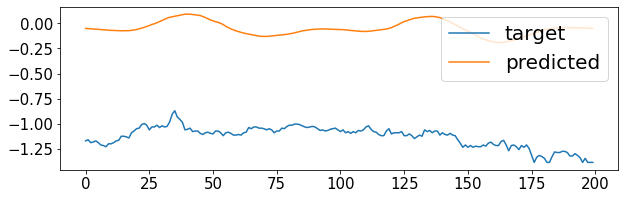

In [43]:
plt.figure(figsize=(10, 3))
plt.plot(y_target[:200], label='target')
plt.plot(y_hat[:200], label='predicted')
plt.legend(loc='upper right', fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [44]:
print('Test Loss :', test_loss)

Test Loss : 0.48110546674734306
